## MORDM for the optimized policies

> In this notebook we evaluate the candidate solutions under uncertainities and finalize a policy lever for the province. In addition to this, we also asssess the impact of this policy on other provinces and scenarios leading to failure of the selected policy.

In [1]:
from __future__ import (unicode_literals, print_function, absolute_import, division)
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario,SequentialEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
import time
from problem_formulation import get_model_for_problem_formulation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import copy
from ema_workbench import save_results
from ema_workbench import load_results


In [3]:
# Read optimized policies (pereto set)
optimized_policies = pd.read_csv('data_processed/mordm/optimized_policies.csv')
len(optimized_policies)

1045

In [4]:
# Subset policies resulting zero deaths in the Gelderland
optimized_policies = optimized_policies[optimized_policies['A.1_Expected Number of Deaths']+optimized_policies['A.2_Expected Number of Deaths']+optimized_policies['A.3_Expected Number of Deaths'] == 0]

print(f' Number of policies subset resulting zero deaths in the province  = {len(optimized_policies)}')

 Number of policies subset resulting zero deaths in the province  = 31


In [5]:
# Subset policies with 10 percentile RFR cost i.e. 199900000
optimized_policies = optimized_policies[optimized_policies['RfR Total Costs'] <optimized_policies['RfR Total Costs'].quantile(0.1)]
print(f' Number of policies subset resulting least RFR cost (i.e. < 10 percentile)  = {len(optimized_policies)}')

 Number of policies subset resulting least RFR cost (i.e. < 10 percentile)  = 3


In [6]:
# Separate levers and outcomes

levers = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']


optimized_policies = optimized_policies.loc[:,levers]

In [7]:
# Format the policies according to ema_workbench sytax List of dicts[{},{},{}]
policies_to_evaluate = []

for index,policy in optimized_policies.iterrows():
    policies_to_evaluate.append(Policy(str(index),**policy.to_dict()))

In [8]:
dike_model, planning_steps = get_model_for_problem_formulation(7)

In [9]:
# dike_model, planning_steps = get_model_for_problem_formulation(7)

# n_scenarios = 1000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

# save_results((experiments, outcomes), 'data_processed/mordm/optimized_policies_evaluation.tar.gz')

In [10]:
experiments, outcomes = load_results('data_processed/mordm/optimized_policies_evaluation.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/anmolsoni/Downloads/epa1361_open-master/final assignment/data_processed/mordm/optimized_policies_evaluation.tar.gz


In [11]:
# Function to calculate signal to noise ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction== 'ScalarOutcome.MAXIMIZE':
        return mean/std
    else:
        return mean*std

In [12]:
# Calculate signal to noise ratio

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

A.1_Expected Number of Deaths  A.1_Expected Annual Damage  \
439                    9.372650e-09                1.397685e+12   
574                    3.981696e-03                8.545514e+15   
1036                   1.303234e-04                3.423217e+14   

      A.1_Dike Investment Costs  A.2_Expected Number of Deaths  \
439                    8.640064                   7.495137e-07   
574                    0.904758                   1.632525e-05   
1036                   2.921911                   1.026282e-05   

      A.2_Expected Annual Damage  A.2_Dike Investment Costs  \
439                 6.300487e+13                   0.000000   
574                 2.012473e+13                   0.000000   
1036                1.154583e+13                   7.977736   

      A.3_Expected Number of Deaths  A.3_Expected Annual Damage  \
439                        0.000001                3.609978e+13   
574                        0.000027                1.313662e+13   
1036                       0.000044                1.959618e+13   

      A.3_Dike Investment Costs  RfR Total Costs  Expected Evacuation Costs  
439                    1.997287              0.0               5.144589e+06  
574                    0.000000              0.0               0.000000e+00  
1036                   0.000000              0.0               0.000000e+00

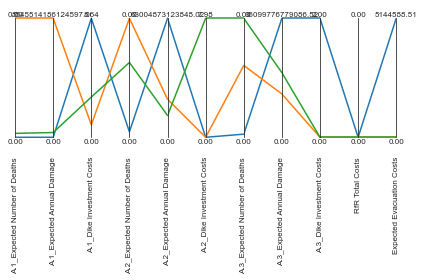

In [13]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)

limits.iloc[0,:] = 0

paraxes = parcoords.ParallelAxes(limits,fontsize = 8)
paraxes.plot(data)
plt.show()


In [14]:
# Function to calculate max regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [15]:
# Calculate max regret
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    

    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

<ipython-input-15-bc2df24c8de7>:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


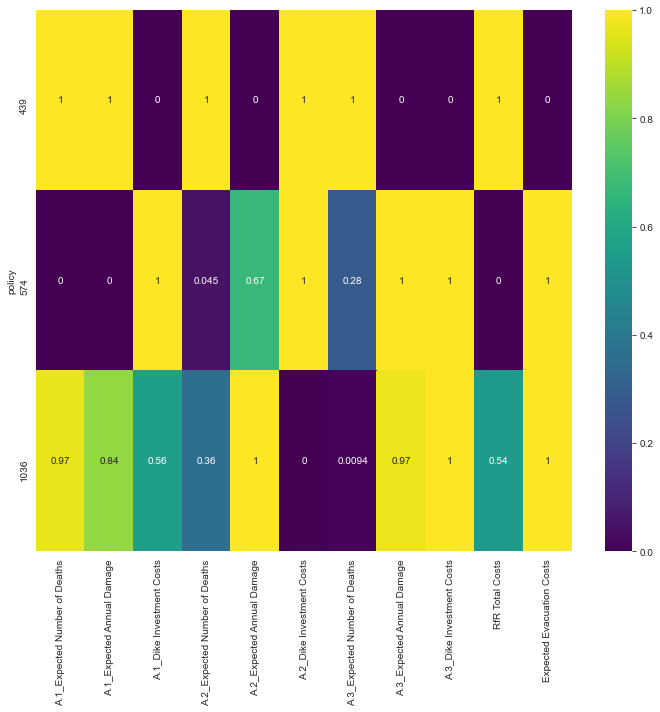

In [16]:
# Plot results of max regret
max_regret = pd.DataFrame(max_regret)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
ax.figure.tight_layout()
plt.show()
fig.savefig('analysis_figures/mordm/robustness_maxregret.png', dpi=300)

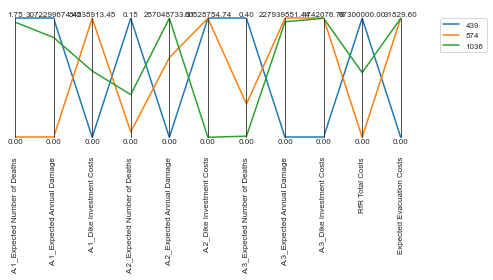

In [17]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=8)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()   
plt.show()

Note: Regret for number of deaths is higher in the policy 574 therefore it is not preferred.

In [18]:

from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]
        

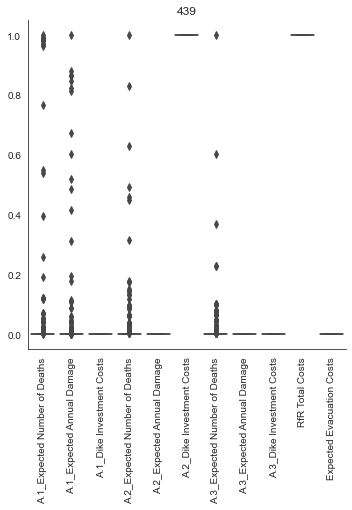

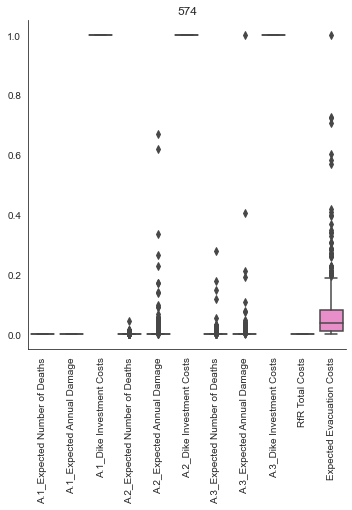

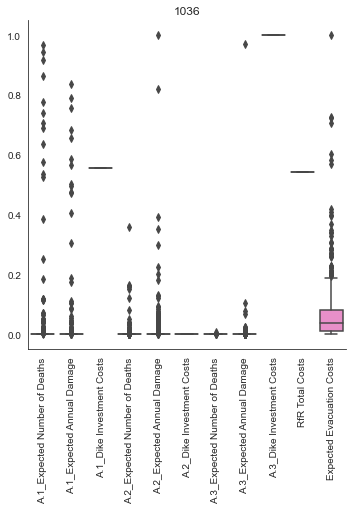

In [19]:


for policy, regret in policy_regret.items():
    data = pd.DataFrame(regret)
    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    fig, ax = plt.subplots(figsize=(5,7))
    sns.boxplot(data=data, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.figure.tight_layout()
    # removes top and left hand black outline of axes
    sns.despine()
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    fig.savefig(f'analysis_figures/mordm/{str(policy)}_maxregret.png', dpi=300)

plt.show()


### Selected policy = 574

* 2_RfR 0               1
* 3_RfR 0               1
* A.1_DikeIncrease 0    6
* A.2_DikeIncrease 0    7
* A.3_DikeIncrease 0    7
* A.3_DikeIncrease 1    7
* A.3_DikeIncrease 2    7
* A.3_DikeIncrease 0    7
* A.4_DikeIncrease 0    6
* A.1_DikeIncrease 0    6
* A.2_DikeIncrease 0    7
* A.3_DikeIncrease 0    7
* A.3_DikeIncrease 1    7
* A.3_DikeIncrease 2    7
* A.4_DikeIncrease 0    6
* A.4_DikeIncrease 1    6
* A.4_DikeIncrease 2    7
* A.5_DikeIncrease 0    3
* A.5_DikeIncrease 1    1
* A.5_DikeIncrease 2    4

In [20]:
# Subset experiments and outcomes for selected policy
experiments = experiments[experiments.policy == 574]

outcomes = pd.DataFrame.from_dict(outcomes)
outcomes = outcomes[outcomes.index.isin(experiments.index)]

In [21]:
outcomes_1 = {}
for entry in outcomes.columns:
    outcomes_1[str(entry)] = outcomes[entry].values

### Identify limiting scenarios (uncertainities) where policy yields undersirable results (failure)

In [22]:
from ema_workbench.analysis import prim
# Remove levers from the file
x = experiments.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2','scenario', 'policy', 'model'])

# failure scenario discovery 
y = outcomes_1['A.2_Expected Annual Damage']>0.2

prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 69 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.057, coverage: 0.8260869565217391, density: 1.0 restricted_dimensions: 4


In [23]:
box.inspect_tradeoff()


alt.VConcatChart(...)

In [24]:

box.inspect(50)

coverage    0.927536
density     0.941176
id                50
mass           0.068
mean        0.941176
res_dim            3
Name: 50, dtype: object

                           box 50                                           
                              min         max                      qp values
A.2_pfail                0.000649    0.072211  [-1.0, 5.454910298987667e-66]
A.1_pfail                0.088464    0.999474    [0.32133851182361045, -1.0]
A.0_ID flood wave shape  6.500000  132.000000      [0.628896775544079, -1.0]



Thus, selected policy might result in undersirable results when uncertainities are in aforementioned range. 

## Checking political impact of the selected policy
Lastly, we want to check the impact of selected policy in other provinces as well for having a political leverage to convince other actors and provinces. Therefore, we are re-running the model one last time with problem formulation == 3.

In [9]:
selected_policy = pd.DataFrame(optimized_policies.loc[574,:]).T
# Format the policies according to ema_workbench sytax List of dicts[{},{},{}]
policies_to_evaluate = []

for index,policy in selected_policy.iterrows():
    policies_to_evaluate.append(Policy(str(index),**policy.to_dict()))

In [10]:
#   # Run the model for getting the impact on other provinces
# dike_model, planning_steps = get_model_for_problem_formulation(3)

# n_scenarios = 1000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

# save_results((experiments, outcomes), 'data_processed/mordm/policy_political_evaluation.tar.gz')

In [11]:
# Load results from the previous run
experiments, outcomes = load_results('data_processed/mordm/policy_political_evaluation.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/anmolsoni/Downloads/epa1361_open-master/final assignment/data_processed/mordm/policy_political_evaluation.tar.gz


In [12]:
# Extract outcomes of interest
outcomes_df =  pd.DataFrame.from_dict(outcomes)
outcomes_df = outcomes_df[['A.4_Expected Number of Deaths','A.5_Expected Number of Deaths']]

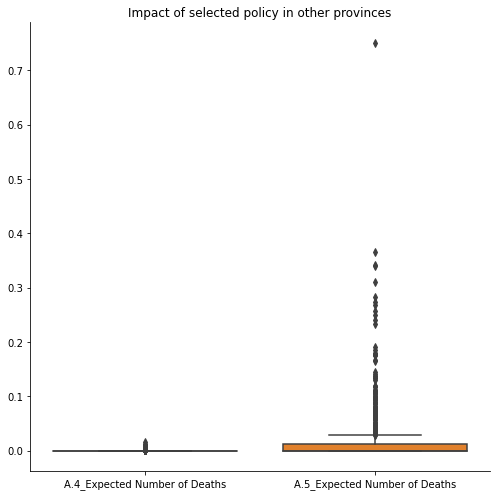

In [13]:
# Plot outcomes of interst
fig, ax = plt.subplots(figsize=(7,7))
sns.boxplot(data=outcomes_df)
ax.set_title('Impact of selected policy in other provinces')
ax.figure.tight_layout()
sns.despine()
plt.show()
fig.savefig(f'analysis_figures/mordm/impact_on_other_provinces.png', dpi=300)

> We can see the despite implementing the policy, there could be certain deaths in Deventer. 
 To avoid it and to further investigate, we perform scenario discovery leading to deaths in other province.

### Scenario discovery for scenarios resulting high deaths in Deventer.

In [14]:
from ema_workbench.analysis import prim
# Remove levers from the file
x = experiments.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2','scenario', 'policy', 'model'])

# failure scenario discovery 
y = outcomes_df['A.5_Expected Number of Deaths']>0.05

prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 93 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.056, coverage: 0.6021505376344086, density: 1.0 restricted_dimensions: 5


In [100]:
box.inspect_tradeoff()

alt.VConcatChart(...)

In [101]:
box.inspect(47)

coverage    0.827957
density     0.950617
id                47
mass           0.081
mean        0.950617
res_dim            3
Name: 47, dtype: object

                           box 47                                           
                              min         max                      qp values
A.5_pfail                0.000012    0.090174  [-1.0, 9.169373343464076e-73]
A.0_ID flood wave shape  0.000000  126.500000     [-1.0, 0.3255186905634861]
A.1_pfail                0.045613    0.999638      [0.315402934182313, -1.0]



> This analysis gives us insight into additional scenarios leading to failure of the policies. Selected policy results in unfavourable outcomes under following scenarios.

In [ ]:
box 47                    min         max
A.5_pfail                0.000012    0.090174
A.0_ID flood wave shape  0.000000    126.500000
A.1_pfail                0.045613    0.999638